In [28]:
# install libraries we will use
!pip3 install ray pandas faker plotly altair vega sklearn

Processing /Users/jonathandinu/Library/Caches/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074/sklearn-0.0-py2.py3-none-any.whl
     |████████████████████████████████| 7.2 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 28.9 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 270 kB/s eta 0:00:01


In [29]:
from urllib.parse import urlparse
from io import StringIO
from collections import Counter
from time import sleep
import random, logging
from itertools import combinations

import ray
import pandas as pd
import numpy as np
import sklearn

## Let's index the internet!

In [2]:
#internet = requests.get('https://moz.com/top-500/download?table=top500Domains').text

In [3]:
df = pd.read_csv('internet.csv')
df

,Rank,Root Domain,Linking Root Domains,Domain Authority
0,1,apple.com,"4,600,902",100
1,2,youtube.com,"17,811,336",100
2,3,www.google.com,"12,131,939",100
3,4,www.blogger.com,"25,278,670",99
4,5,docs.google.com,"2,273,261",99
...,...,...,...,...
495,496,lonelyplanet.com,"152,050",92
496,497,entrepreneur.com,"220,299",92
497,498,inc.com,"208,880",92
498,499,fda.gov,"281,189",92


In [4]:
ray.init(ignore_reinit_error=True, logging_level=logging.ERROR)

{'node_ip_address': '192.168.1.107',
 'raylet_ip_address': '192.168.1.107',
 'redis_address': '192.168.1.107:6379',
 'object_store_address': '/tmp/ray/session_2020-09-01_11-21-10_724071_92755/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-09-01_11-21-10_724071_92755/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-09-01_11-21-10_724071_92755'}

In [5]:
@ray.remote
def f(x):
    return x * x

futures = [f.remote(i) for i in range(4)]
print(ray.get(futures))

[0, 1, 4, 9]


In [6]:
@ray.remote
def index(url):
    print(f"I'm Sleeping on {url}")
    sleep(.5)
    print(f"I'm Awake, time to get {url}")
    return url.split('.')[-1]

futures = [index.remote(site) for site in df['Root Domain'].to_list()[:5]]
Counter(ray.get(futures))

(pid=92781) I'm Sleeping on youtube.com
(pid=92782) I'm Sleeping on www.blogger.com
(pid=92778) I'm Sleeping on www.google.com
(pid=92779) I'm Sleeping on apple.com
(pid=92780) I'm Sleeping on docs.google.com
(pid=92777) I'm Sleeping on support.google.com
(pid=92776) I'm Sleeping on linkedin.com
(pid=92775) I'm Sleeping on cloudflare.com
(pid=92773) I'm Sleeping on wordpress.org
(pid=92771) I'm Sleeping on microsoft.com
(pid=92774) I'm Sleeping on en.wikipedia.org
(pid=92772) I'm Sleeping on play.google.com
(pid=92781) I'm Awake, time to get youtube.com
(pid=92781) I'm Sleeping on adobe.com
(pid=92782) I'm Awake, time to get www.blogger.com
(pid=92782) I'm Sleeping on youtu.be
(pid=92778) I'm Awake, time to get www.google.com
(pid=92778) I'm Sleeping on mozilla.org
(pid=92779) I'm Awake, time to get apple.com
(pid=92779) I'm Sleeping on googleusercontent.com
(pid=92780) I'm Awake, time to get docs.google.com
(pid=92780) I'm Sleeping on plus.google.com
(pid=92777) I'm Awake, time to get

Counter({'com': 23, 'org': 4, 'eu': 1, 'be': 1, 'uk': 1})

(pid=92781) I'm Awake, time to get bp.blogspot.com
(pid=92779) I'm Awake, time to get vk.com
(pid=92780) I'm Awake, time to get istockphoto.com
(pid=92773) I'm Awake, time to get creativecommons.org
(pid=92774) I'm Awake, time to get facebook.com
(pid=92772) I'm Awake, time to get bbc.co.uk


## Dashboard

![](images/ray-dash.gif)

## Introducing Actors (stateful tasks)

Scheme made them [concrete](https://dspace.mit.edu/handle/1721.1/5794). Erlang made them [useful](https://erlang.org/doc/getting_started/conc_prog.html). Akka made them [cool](https://akka.io/). And now Ray makes them [easy](https://docs.ray.io/en/latest/ray-overview/index.html)!

In [7]:
@ray.remote
class Child(object):
    def __init__(self):
        from faker import Faker
        self.name = Faker().name()
        self.age = 1

    def grow(self):
        self.age += 1
        return self.age

    def greet(self):
        return (
            f'My name is {self.name} '
            f'and I am {self.age} years old'
        )

In [8]:
children = [Child.remote() for i in range(10)]

for c in children:
    for _ in range(random.randint(1, 10)):
        c.grow.remote()
        
futures = [c.greet.remote() for c in children]

for future in ray.get(futures):
    print(future)

My name is Kelli Johnson and I am 7 years old
My name is John Odonnell and I am 6 years old
My name is Brian Dean and I am 8 years old
My name is Aaron Ritter and I am 11 years old
My name is Lisa Lopez and I am 4 years old
My name is Daniel Parsons and I am 3 years old
My name is Shelia Sanchez and I am 11 years old
My name is Maria Boyle and I am 8 years old
My name is Angela Cruz and I am 5 years old
My name is Michael Morris and I am 9 years old


In [9]:
c = children[0]

In [10]:
print(ray.get([c.grow.remote() for _ in range(5)]))

[8, 9, 10, 11, 12]


In [11]:
# actors stay around as long as they are in scope
# since nothing really goes out of scope in a notebook
# we have to manually terminate them
[ ray.kill(person) for person in children ]

[None, None, None, None, None, None, None, None, None, None]

In [12]:
# or just shutdown ray
ray.shutdown()

## Simulating a pandemic

> note this is a toy model simulation, results should not be used to inform health decisions or personal behavior

### The SIR epidemic model:

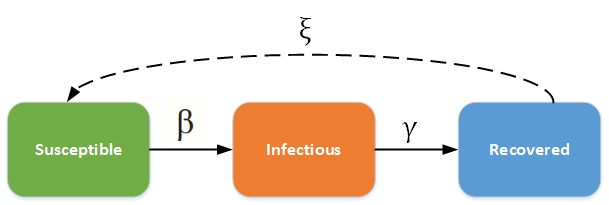

$S(t)$: susceptible individuals who have not yet been infected at time $t$

$I(t)$: number of infections individuals at time $t$

$R(t)$: number of individuals who have recovered (and are immune) at time $t$

#### Parameters

$\beta$: probablity of transmitted the disease from an infected to a susceptible individual

$\gamma$: recovery rate ~ $\frac{1}{\text{duration of disease}}$

We will follow the [EMOD compartamental model](https://idmod.org/docs/emod/malaria/model-compartments.html) to simulate the SIR model as a series of discrete timesteps. For something like reinforcement learning, instead of disease dynamics you simulate actions in an environment/game.

In [13]:
ray.init(ignore_reinit_error=True, logging_level=logging.ERROR)

In [14]:
# parameters
b = 0.5
b_0 = 0.2
g = 0.2
dim = 5

@ray.remote
class Person(object):
    def __init__(self, i):
        self.index = i
        self.state = 'i' if random.random() < b_0 else 's'
        self.x = random.randint(0, dim)
        self.y = random.randint(0, dim)

    def location(self):
        return (self.x, self.y)
    
    def health(self):
        return self.state
    
    def index(self):
        return self.index
    
    def status(self):
        return f"Individual {self.index} at {self.location()} is currently {self.state}"
        
    # Just getters/setters above 👆
    
    # Actual methods below 👇
    def walk(self):
        if self.state == 'i':
            if random.random() < g:
                print(f"Individual {self.index} has recovered 🤗")
                self.state = 'r'
                
        self.x += random.randint(-1, 1)
        self.x += random.randint(-1, 1)
        
        self.x = max(min(self.x, dim), 0)
        self.y = max(min(self.y, dim), 0)
        
    def contract(self):
        print(f"{self.index} has become sick 🤮")
        self.state = 'i'
    
    def interact(self, stranger):
        x, y = ray.get(stranger.location.remote())
        state = ray.get(stranger.health.remote())
        
        # is the stranger close to me
        if (abs(x - self.x) <= 1) and (abs(y - self.y) <= 1):
            # is either of us infected?
            if self.state == 'i' or state == 'i':
                # can either of us _get_ infected?
                if self.state == 's' or state == 's':
                    # which one of us can get the disease
                    target = self.contract if self.state == 's' else stranger.contract.remote
                    
                    # roll the dice babeeeeee
                    if random.random() < b:
                        target()                

In [19]:
people = [Person.remote(i) for i in range(10)]

In [20]:
person = people[0]

In [21]:
ray.get(person.location.remote())

(0, 3)

In [22]:
ray.get([p.location.remote() for p in people])

[(0, 3),
 (5, 3),
 (10, 10),
 (5, 2),
 (5, 1),
 (4, 0),
 (8, 8),
 (1, 5),
 (4, 1),
 (6, 3)]

In [24]:
ray.get([p.health.remote() for p in people])

['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']

In [25]:
for person in people:
    ray.kill(person)

In [26]:
ray.get([p.health.remote() for p in people])

RayActorError: The actor died unexpectedly before finishing this task.

In [27]:
people = [Person.remote(i) for i in range(10)]

In [29]:
for person1, person2 in combinations(people, 2):
    person1.interact.remote(person2)

In [30]:
ray.shutdown()
ray.init(ignore_reinit_error=True, logging_level=logging.ERROR)

{'node_ip_address': '192.168.1.107',
 'raylet_ip_address': '192.168.1.107',
 'redis_address': '192.168.1.107:6379',
 'object_store_address': '/tmp/ray/session_2020-09-01_00-30-25_928479_89641/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-09-01_00-30-25_928479_89641/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-09-01_00-30-25_928479_89641'}

## Putting it all together

In [15]:
n = 15

progress = {
    's': [],
    'i': [],
    'r': []
}

people = [Person.remote(i) for i in range(n)]

for i in range(20):
    print(f"\nIteration {i}\n\n")
    for k in progress:
        progress[k].append(0)
        
    for person in people:
        person.walk.remote()
        
    # everybody's mingling....
    pairs = list(combinations(people, 2))
            
    for p1, p2 in pairs:
        p1.interact.remote(p2)
        
    for p in people:
        progress[ray.get(p.health.remote())][-1] += 1


Iteration 0


(pid=92818) Individual 8 has recovered 🤗
(pid=92874) Individual 32 has recovered 🤗
(pid=92910) 47 has become sick 🤮
(pid=92885) 34 has become sick 🤮
(pid=92872) 30 has become sick 🤮
(pid=92915) 49 has become sick 🤮
(pid=92871) 27 has become sick 🤮
(pid=92881) 33 has become sick 🤮
(pid=92892) 38 has become sick 🤮
(pid=92851) 21 has become sick 🤮
(pid=92890) 36 has become sick 🤮
(pid=92845) 18 has become sick 🤮
(pid=92848) 17 has become sick 🤮
(pid=92823) 9 has become sick 🤮
(pid=92821) 10 has become sick 🤮
(pid=92895) 41 has become sick 🤮
(pid=92822) 3 has become sick 🤮
(pid=92815) 7 has become sick 🤮
(pid=92817) 1 has become sick 🤮

Iteration 1


(pid=92822) Individual 3 has recovered 🤗
(pid=92852) 23 has become sick 🤮
(pid=92885) Individual 34 has recovered 🤗
(pid=92898) 42 has become sick 🤮
(pid=92909) Individual 46 has recovered 🤗
(pid=92910) Individual 47 has recovered 🤗
(pid=92886) 35 has become sick 🤮
(pid=92867) 28 has become sick 🤮
(pid=92844) 15 has become sick 

In [16]:
df = pd.DataFrame(progress).reset_index()
melted = pd.melt(df, id_vars=['index'], value_vars=['s', 'i', 'r'])
melted.columns = ['index', 'variable', 'percent']
melted.loc[melted.variable == "s", "status"] = 'Susceptible'
melted.loc[melted.variable == "i", "status"] = 'Infected'
melted.loc[melted.variable == "r", "status"] = 'Recovered'
melted['percent'] = melted.percent / n
melted.head()

,index,variable,percent,status
0,0,s,0.50,Susceptible
1,1,s,0.38,Susceptible
2,2,s,0.32,Susceptible
3,3,s,0.24,Susceptible
4,4,s,0.22,Susceptible


In [17]:
for person in people:
    print(ray.get(person.status.remote()))

Individual 0 at (4, 9) is currently s
Individual 1 at (8, 7) is currently r
Individual 2 at (4, 1) is currently r
Individual 3 at (6, 2) is currently r
Individual 4 at (2, 9) is currently s
Individual 5 at (7, 5) is currently i
Individual 6 at (3, 3) is currently r
Individual 7 at (4, 8) is currently r
Individual 8 at (1, 8) is currently r
Individual 9 at (2, 5) is currently r
Individual 10 at (5, 7) is currently r
Individual 11 at (5, 9) is currently s
Individual 12 at (9, 9) is currently s
Individual 13 at (0, 7) is currently r
Individual 14 at (2, 0) is currently r
Individual 15 at (4, 4) is currently r
Individual 16 at (3, 10) is currently s
Individual 17 at (1, 0) is currently r
Individual 18 at (3, 0) is currently r
Individual 19 at (4, 4) is currently r
Individual 20 at (3, 3) is currently r
Individual 21 at (8, 0) is currently r
Individual 22 at (6, 0) is currently r
Individual 23 at (8, 6) is currently r
Individual 24 at (5, 4) is currently r
Individual 25 at (4, 4) is current

In [18]:
import altair as alt

In [19]:
alt.Chart(melted, width=800).mark_area().encode(
        alt.X(
            "index", 
            scale=alt.Scale(domain=(0, 19)),
            axis=alt.Axis(title="t")
            ), 
        alt.Y(
            "percent", 
            stack="normalize",
            axis=alt.Axis(
                title=" ",
                format="%"
            )
        ),
        color=alt.Color('status', 
                        legend=alt.Legend(title="Individuals"), 
                        scale=alt.Scale(
                            domain=['Infected', 'Recovered', "Susceptible"],
                            range=['rgb(242, 34, 255)', 'rgb(144, 244, 148)', 'rgb(167, 184, 227)']
                            )
                       ),
        tooltip=['percent', 'status']
).interactive()

alt.Chart(...)

In [20]:
ray.shutdown()

## All communication, no computation... the Parameter Server

[From dive into Deep learning](https://d2l.ai/chapter_computational-performance/parameterserver.html) 👇
![](https://d2l.ai/_images/ps-multimachine.svg)

In [21]:
ray.init(ignore_reinit_error=True, logging_level=logging.ERROR)

{'node_ip_address': '192.168.1.107',
 'raylet_ip_address': '192.168.1.107',
 'redis_address': '192.168.1.107:6379',
 'object_store_address': '/tmp/ray/session_2020-09-01_11-22-53_390392_92755/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-09-01_11-22-53_390392_92755/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-09-01_11-22-53_390392_92755'}

In [22]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [23]:
@ray.remote
class ParameterServer(object):
    def __init__(self, dim, lr):
        self.lr = lr
        self.params = np.zeros(dim)

    def get_params(self):
        return self.params

    def update_params(self, grads):
        for grad in grads:
            self.params -= self.lr * grad

In [24]:
@ray.remote
class Worker(object):
    def __init__(self, ps, data):
        # reference to Parameter Server
        self.ps = ps
        self.batch = data
        
    def calc_gradients(self):
        theta = ray.get(ps.get_params.remote())
        
        X = self.batch[:, :-1]
        y = self.batch[-1]
        z = np.dot(X, theta)
        
        return np.dot(X.T, (sigmoid(z) - y)) / len(y)

In [36]:
# instantiate a parameter server with 100 parameters and a learning rate of 0.01
server = ParameterServer.remote(100, 0.01)

# store parameter server in shared memory as remote object
ps = ray.put(server)
num_workers = 4

In [26]:
print(server)
print(ps)

Actor(ParameterServer, 85e8f9fc0100)
ObjectRef(ffffffffffffffffffffffff0100008001000000)


In [35]:
from sklearn.datasets import load_iris
iris = load_iris()

In [40]:
data = np.array_split(iris.data, num_workers)

In [46]:
assert(iris.data.shape[1] == data[0].shape[1])

In [ ]:
epochs = 10

for i in range(epochs):
    ps.update_params.remote([ worker.calc_gradients.remote() for worker in workers ])